# SR Volume by Status (YTD)

This notebook processes the SRM raw data as required and produces the graph for the SR volume by status, as used in the SRM datapack.

## Steps

1. Upload current status standing data and raw data
2. Keep necessary columns, remove the unnecessary ones from raw data
3. Create "Most Recent Action Column" and append to raw data
4. Merge raw-data with standing data
5. Add status column
6. Make graph


In [16]:
# IMPORTS AND STANDING DATA
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

#status standing data
current_status = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-current-status.csv')
current_status.head(5)

,Current State,User Currently With,Status,Status (Updated)
0,Saved,Not Applicable,Not submitted,SR Created - Accounting unit
1,Sent to Spending Team Secretary,Spending Team Secretary (Start),In process,Under Review - GDPA
2,Revoked,Ministry,Revoked,Revoked - AU
3,Approval No Issued,Ministry - Approved,Approved,Approved - Inactive
4,Output ID issued,Ministry - Rejected,Rejected,Rejected - Inactive


In [3]:
# Import Raw Data and drop unneeded columns
df = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/raw-data/srm-raw-data/230301-srm-raw-data.csv', low_memory=False)
#df
# Columns to keep immediately
df_columns_to_keep = [
        'Srid','Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Entity','Account Code','Exchange Rate','Total Cost Of Line','Amended Total Cost Of Line',
        'Savings Of Line','Total Sr Savings','Spending Team Action','Spending Team Action Date',
        'Price Evaluation Action','Price Evaluation Action Date','Engineering Directorate Action',
        'Engineering Directorate Action Date','Publications Directorate Action','Publications Directorate Action Date',
        'Director Of Spending Action','Director Of Spending Action Date','Dg Pa Action','Dg Pa Action Date',
        'Minister Of Finance Action','Minister Of Finance Action Date','Com Action','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date','Second Round Com Action Date',
        'Second Round Final Approval Date','Final Approval Date','Current State']
df_filtered = df.loc[:, df_columns_to_keep]
#df_filtered.head(5)


In [4]:
# Define function to remove extra characters from string
def remove_extra_chars(string):
    return string.split(' $')[0]

# Apply function to 'Current State' column
df['Current State'] = df['Current State'].apply(remove_extra_chars)

# Display updated dataframe
#df['Current State'].unique()

In [5]:
# Create a Most Recent Action column
columns_to_include = [
        'Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Spending Team Action Date',
        'Price Evaluation Action Date',
        'Engineering Directorate Action Date','Publications Directorate Action Date',
        'Director Of Spending Action Date','Dg Pa Action Date',
        'Minister Of Finance Action Date','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date',
        'Second Round Com Action Date','Second Round Final Approval Date','Final Approval Date']

df_filtered['Most Recent Action'] = df_filtered[columns_to_include].max(axis=1)

In [6]:

# convert date_column to datetime format
df_filtered['Most Recent Action'] = pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d %I:%M %p', errors='coerce').fillna(pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d', errors='coerce'))
#df_filtered['Most Recent Action']


In [7]:
# Merge standing data and raw data to get the status'
current_status['Current State'] = current_status['Current State'].str.upper()
df_filtered['Current State'] = df_filtered['Current State'].str.upper()
df_filtered = pd.merge(df_filtered, current_status,how='left', on='Current State')
#df_filtered.head(5)
#current_status.head(10)

In [8]:
#ADD STATUS COLUMN
def final_status(row):
    if row['Current State'] == "REVOKED" and row['Date Submitted To Mofe'] == "-":
        return "Not Submitted"
    
    elif row['Current State'] == "REVOKED" and row['Final Approval Date'] != "-":
        if row[26] == "Approved By Minister Of Finance" or row[26] == "Amended and Approved By Minister Of Finance" or  row[26] == "Pending Tender":
            return "Revoked After Approval"
        
        elif row[28] == "Approved By Council Of Ministers" or row[28] == "Amended And Approved By Council Of Ministers" or row[28] == "Pending Tender By Council Of Ministers":
            return "Revoked After Approval"
        
        elif row[26] == "Rejected By Minister Of Finance" or row[28] == "Rejected By Council Of Ministers":
            return "Revoked After Rejection"
        
    elif row[42] == 'In process':
        return 'In Process'
    
    elif row[42] == 'Not submitted':
        return 'Not Submitted'
    
    elif row[42] == 'Revoked':
        return 'Revoked'
    
    elif row[42] == 'Rejected':
        return 'Rejected'
    
    elif row[42] == 'Approved':
        if row[13] == 0:
            return 'Approved'
        else:
            return 'Amended'
    else:
        return np.nan
    
df_filtered['Final Status'] = df_filtered.apply(final_status, axis=1)

# Make the table for the graph below here


In [9]:
# Volumes by status dataframe code
# define the index and columns
index = [datetime(2022,7,1),datetime(2022,8,1),datetime(2022,9,1),datetime(2022,10,1),
         datetime(2022,11,1),datetime(2022,12,1),datetime(2023,1,1),datetime(2023,2,1),
         datetime(2023,3,1),datetime(2023,4,1),datetime(2023,5,1),datetime(2023,6,1),
         datetime(2023,7,1)]
columns = ['Approved', 'Amended', 'Rejected']

# create an empty dictionary to store the calculated values
data = {}
for col in columns:
    data[col] = []

# loop through the date range and calculate the unique sum of Srid column
for i in range(len(index)-1):
    start_date = index[i]
    end_date = index[i+1]
    for col in columns:
        total = df_filtered[(df_filtered['Final Status'] == col) & 
                            (df_filtered['Most Recent Action'] >= start_date) &
                            (df_filtered['Most Recent Action'] < end_date)]['Srid'].nunique()
        data[col].append(total)

# create the dataframe
volume_by_status_df = pd.DataFrame(data=data, index=index[:-1], columns=columns)


In [14]:
volume_by_status_df

,Approved,Amended,Rejected
2022-07-01,271,70,7
2022-08-01,683,291,182
2022-09-01,580,233,96
2022-10-01,662,244,116
2022-11-01,479,276,43
2022-12-01,374,122,20
2023-01-01,123,42,16
2023-02-01,678,160,20
2023-03-01,0,0,0
2023-04-01,0,0,0


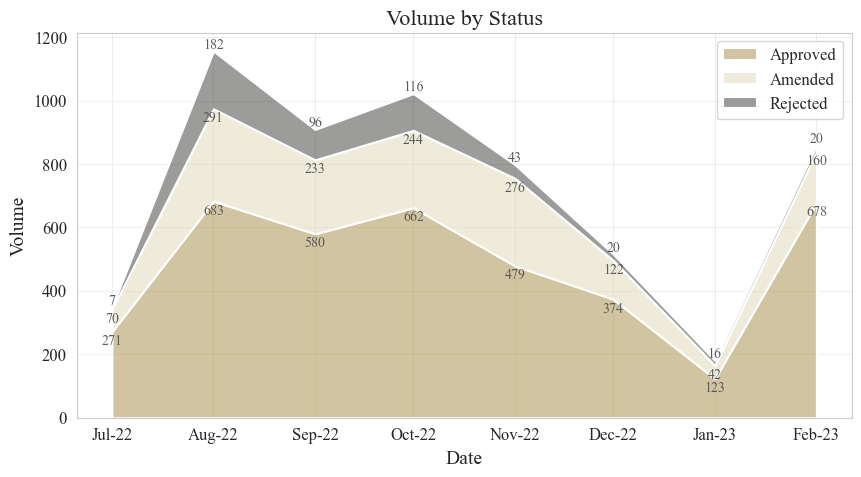

In [38]:
# set the font family and size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# set the figure size
fig, ax = plt.subplots(figsize=(10, 5))

# slice the volume_by_status_df dataframe to exclude the last 4 rows
volume_by_status_df_slice = volume_by_status_df.iloc[:-4]
ax.grid(True, alpha=0.3)
fill_colors = ['#a58b4280','#dfd8b880','#3b3a3780']

# create the stacked filled line graph with the specified colors
plt.stackplot(volume_by_status_df_slice.index, volume_by_status_df_slice.T, labels=volume_by_status_df_slice.columns,
              colors=fill_colors, linewidth=1.5)
plt.title('Volume by Status',fontname='Times New Roman',fontsize=16)
plt.xlabel('Date',fontname='Times New Roman', fontsize=14)
plt.ylabel('Volume',fontname='Times New Roman',fontsize=14)
plt.legend(loc='upper right')


# set the x-axis tick formatter to display the date in "mmm-yy" format
date_fmt = mdates.DateFormatter('%b-%y')
plt.gca().xaxis.set_major_formatter(date_fmt)

##Add the data labels

# add data labels for each point in the line graph approved line
values = volume_by_status_df_slice['Approved'].values
for i, val in enumerate(values):
    ax.text(volume_by_status_df_slice.index[i], val - 50,
            str(val), ha='center', va='bottom', fontsize=10, color='#595959')

# add data labels for each point in the line graph amended line
values = volume_by_status_df_slice['Amended'].values
for i, val in enumerate(values):
    ax.text(volume_by_status_df_slice.index[i], val + 
            volume_by_status_df_slice.iloc[i,0] - 50,
            str(val), ha='center', va='bottom', fontsize=10, color='#595959')

# add data labels for each point in the line graph rejected line
values = volume_by_status_df_slice['Rejected'].values
for i, val in enumerate(values):
    ax.text(volume_by_status_df_slice.index[i], val + 
            volume_by_status_df_slice.iloc[i,0] + volume_by_status_df_slice.iloc[i,1],
            str(val), ha='center', va='bottom', fontsize=10, color='#595959')
        
# display the graph
plt.show()